# 1. Cài đặt package

In [2]:
!pip install pytorch-lightning
!pip install torch 
!pip install torchvision 
!pip install torchmetrics 

## 2. Khai báo thư viện 


In [11]:
%matplotlib inline

import os
from collections import OrderedDict
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST, FashionMNIST

PATH_DATASETS = 'data'
os.makedirs(PATH_DATASETS, exist_ok=True)
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64

# 3. Khởi tạo module dữ liệu 

In [4]:
class DataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = PATH_DATASETS,
        batch_size: int = BATCH_SIZE,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [   
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )


    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None, data='MNIST'):
        print('Seting')
        # Assign train/val datasets for use in dataloaders
        if data == 'MNIST':
          print('Load MNIST')
          if stage == "fit" or stage is None:
              mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
              self.train, self.val = random_split(mnist_full, [55000, 5000])

          # Assign test dataset for use in dataloader(s)
          if stage == "test" or stage is None:
              self.test = MNIST(self.data_dir, train=False, transform=self.transform)
        if data != 'MNIST':
          print('Load Fmnist')
          if stage == "fit" or stage is None:
              fashion_mnist_full = FashionMNIST(self.data_dir, train=True, transform=self.transform)
              self.train, self.val = random_split(fashion_mnist_full, [55000, 5000])

          # Assign test dataset for use in dataloader(s)
          if stage == "test" or stage is None:
            self.test = FashionMNIST(self.data_dir, train=False, transform=self.transform)
                    

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)


    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

In [5]:
# Doawload data|
mnist = DataModule()
mnist.prepare_data()
fmnist = DataModule()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
mnist.setup(data='MNIST')
m = mnist.train_dataloader()
fmnist.setup(data='FMNIST')
f = fmnist.train_dataloader()

Seting
Load MNIST
Seting
Load Fmnist


# 4. Trực quan hóa dữ liệu

## 4.1 Trực quan bộ dữ liệu MNIS




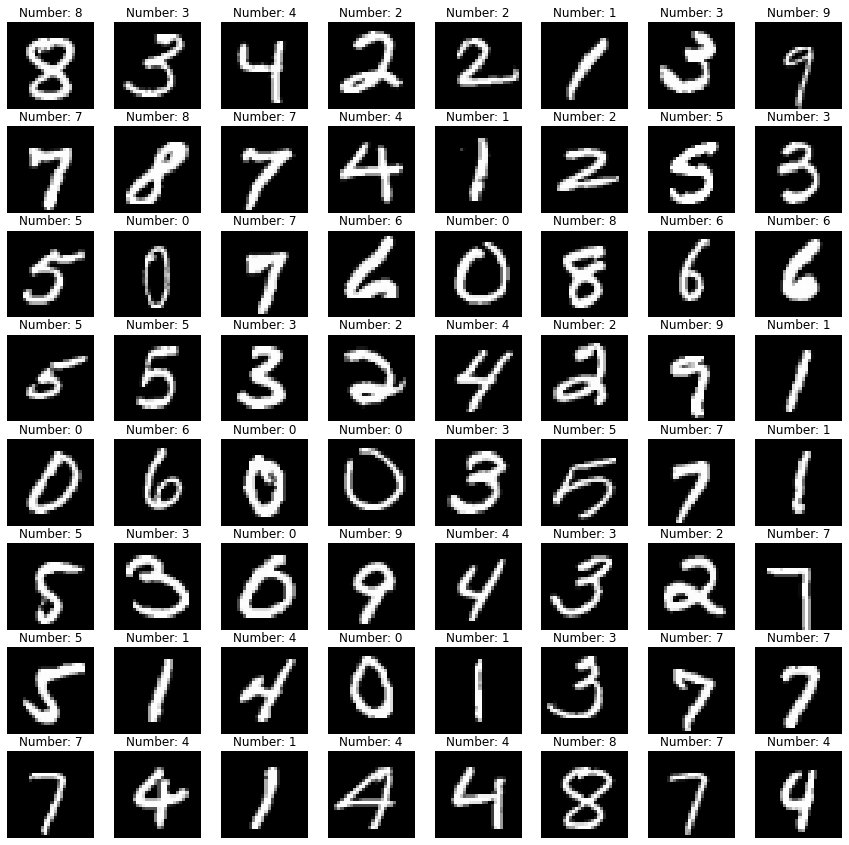

In [6]:
dataiter = iter(m)
images, labels = dataiter.next()
images = images.numpy()

# Trực quan hóa tất cả dữ liệu trong 1 batch gồm 64 ảnh
fig = plt.figure(figsize=(15, 15))
# số lượng sample trên hàng và cột được trực quan
columns = 8
rows = 8
for i in range(1, columns*rows+1):
    img = np.squeeze(images[i-1])
    fig.add_subplot(rows, columns, i).set_title(f'Number: {labels[i-1]}')
    plt.axis('off')
    plt.imshow(img,  cmap='gray')
plt.show()

## 4.2 Trực quan bộ dữ liệu FashionMNIST

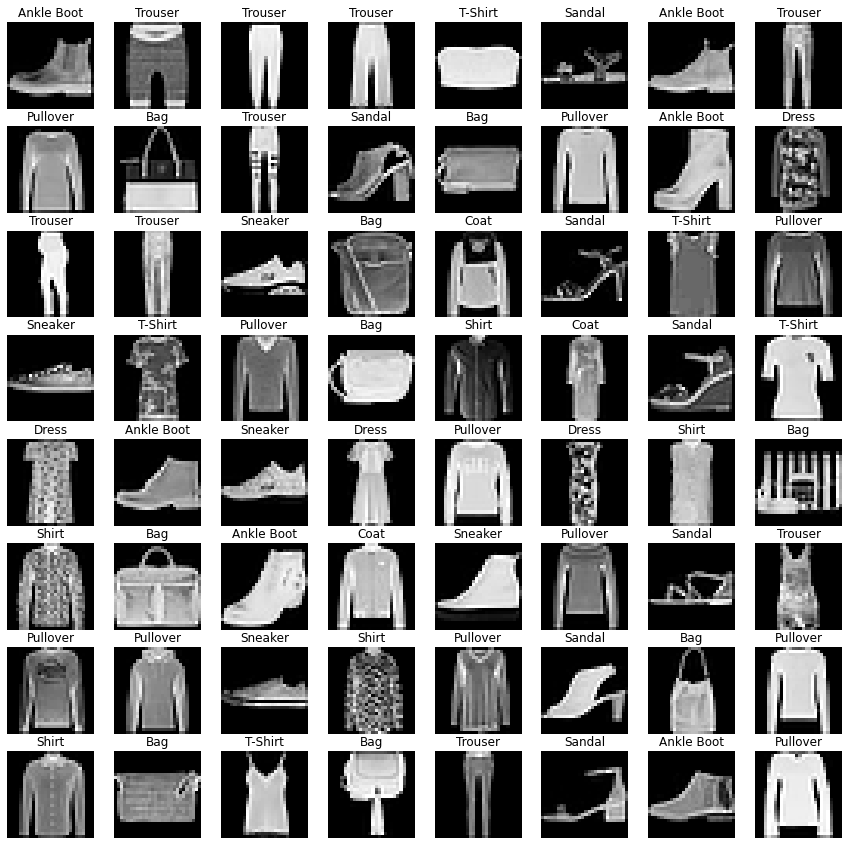

In [7]:
dataiter = iter(f)
images, labels = dataiter.next()
images = images.numpy()
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
# Trực quan hóa tất cả dữ liệu trong 1 batch gồm 64 ảnh
fig = plt.figure(figsize=(15, 15))
# số lượng sample trên hàng và cột được trực quan
columns = 8
rows = 8
for i in range(1, columns*rows+1):
    img = np.squeeze(images[i-1])
    fig.add_subplot(rows, columns, i).set_title(f'{labels_map[int(labels[i-1])]}')
    plt.axis('off')
    plt.imshow(img,  cmap='gray')
plt.show()

# 5. Định nghĩa mô hình

In [7]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.img_shape = 100

        # Embbedding label to link with input
        self.embedding = nn.Embedding(10, 10)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(110, 256, normalize=False),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, z, y):
        # pass the labels into a embedding layer
        labels_embedding = self.embedding(y)
        # concat the embedded labels and the noise tensor
        # z is a tensor of size (batch_size, latent_dim + dim_label_encode)
        z = torch.cat([z, labels_embedding], dim=-1)
        img = self.model(z)
        # model returns three tensors in its forward method: return self.decode(z), mu, logvar
        # so this return tensor and shape
        return img

In [8]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(28 * 28 + 10, 512),

            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z, y):
        # pass the labels into a embedding layer
        labels_embedding = self.embedding(y)
        # concat the embedded labels and the noise tensor
        # z is a tensor of size (batch_size, latent_dim + dim_label_encode)
        z = z.view(z.size(0), -1)
        z = torch.cat([z, labels_embedding], dim=-1)
        img = self.model(z)
        # model returns three tensors in its forward method: return self.decode(z), mu, logvar
        # so this return tensor and shape
        return img

In [9]:
d_loss = []
g_loss = []

samples = []
fixed_z = np.random.uniform(-1, 1, size=(100, 100))
fixed_z = torch.from_numpy(fixed_z).float()

class CGAN(LightningModule):

    def __init__(
            self,
    ):
        super().__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, z, y):
        """
        Generates an image using the generator
        given input noise z and labels y
        """
        return self.generator(z, y)

    def generator_step(self, x):
        """
        Training step for generator
        1. Sample random noise and labels
        2. Pass noise and labels to generator to
           generate images
        3. Classify generated images using
           the discriminator
        4. Backprop loss
        """

        # Sample random noise and labels
        z = torch.randn(x.shape[0], 100, device=device)
        y = torch.randint(0, 10, size=(x.shape[0],), device=device)

        # Generate images
        generated_imgs = self(z, y)
        samples.append(generated_imgs)

        # Classify generated image using the discriminator
        d_output = torch.squeeze(self.discriminator(generated_imgs, y))

        # Backprop loss. We want to maximize the discriminator's
        # loss, which is equivalent to minimizing the loss with the true
        # labels flipped (i.e. y_true=1 for fake images). We do this
        # as PyTorch can only minimize a function instead of maximizing
        g_loss = nn.BCELoss()(d_output,
                              torch.ones(x.shape[0], device=device))

        return g_loss

    def discriminator_step(self, x, y):
        """
        Training step for discriminator
        1. Get actual images and labels
        2. Predict probabilities of actual images and get BCE loss
        3. Get fake images from generator
        4. Predict probabilities of fake images and get BCE loss
        5. Combine loss from both and backprop
        """

        # Real images
        d_output = torch.squeeze(self.discriminator(x, y))
        loss_real = nn.BCELoss()(d_output,
                                 torch.ones(x.shape[0], device=device))

        # Fake images
        z = torch.randn(x.shape[0], 100, device=device)
        y = torch.randint(0, 10, size=(x.shape[0],), device=device)

        generated_imgs = self(z, y)
        d_output = torch.squeeze(self.discriminator(generated_imgs, y))
        loss_fake = nn.BCELoss()(d_output,
                                 torch.zeros(x.shape[0], device=device))

        return loss_real + loss_fake

    def training_step(self, batch, batch_idx, optimizer_idx):
        X, y = batch

        # train generator
        if optimizer_idx == 0:
            loss = self.generator_step(X)
            g_loss.append(loss)

        # train discriminator
        if optimizer_idx == 1:
            loss = self.discriminator_step(X, y)
            d_loss.append(loss)
        self.log("loss", loss)

        return loss

    def configure_optimizers(self):
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        return [g_optimizer, d_optimizer], []

# 6. Huấn luyện mô hình

**6.1 Huấn luyện MNIST**

In [11]:
import pytorch_lightning as pl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CGAN()
trainer = pl.Trainer(max_epochs=50, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, mnist)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.5 M 
1 | discriminator | Discriminator | 538 K 
------------------------------------------------
2.0 M     Trainable params
0     

Training: 0it [00:00, ?it/s]

**6.1.2 Biểu đồ loss của generator và discriminator**

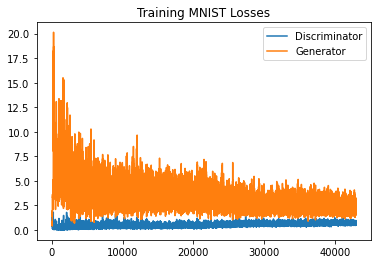

In [12]:
fig, ax = plt.subplots()
plt.plot(d_loss, label='Discriminator')
plt.plot(g_loss, label='Generator')
plt.title("Training MNIST Losses")
plt.legend()

**6.1.3 Sample được tạo từ tập huấn luyện**

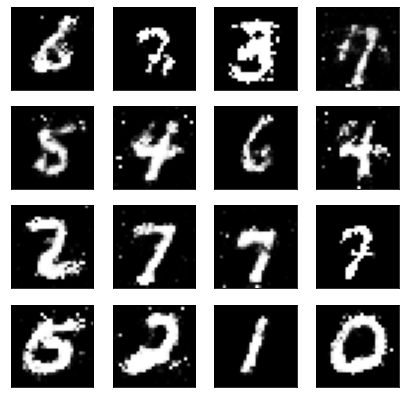

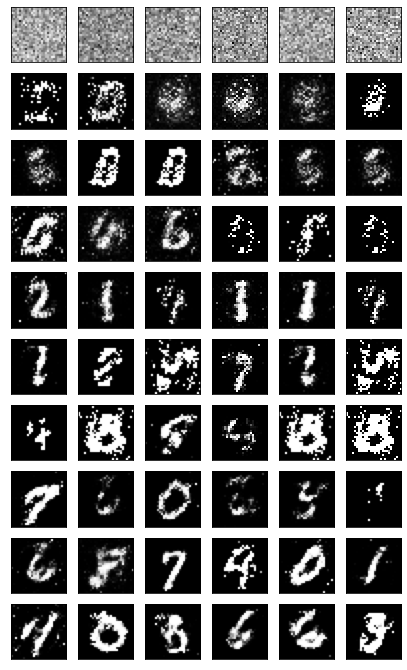

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


view_samples(-1, samples)

rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

**6.2 Huấn luyện FMNIST**



In [14]:
d_loss = []
g_loss = []
samples = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_F = CGAN()
trainer_F = pl.Trainer(max_epochs=50, gpus=1 if torch.cuda.is_available() else 0)
trainer_F.fit(model_F, fmnist)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.5 M 
1 | discriminator | Discriminator | 538 K 
------------------------------------------------
2.0 M     Trainable params
0     

Training: 0it [00:00, ?it/s]

**6.2.2 Biểu đồ loss của generator và discriminator**

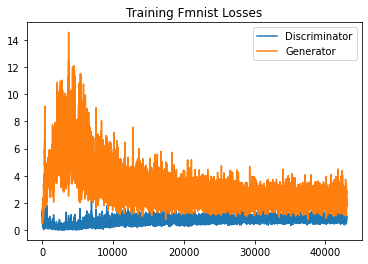

In [15]:
fig, ax = plt.subplots()
plt.plot(d_loss, label='Discriminator')
plt.plot(g_loss, label='Generator')
plt.title("Training Fmnist Losses")
plt.legend()

**6.2.3 Sample được tạo từ tập huấn luyện**

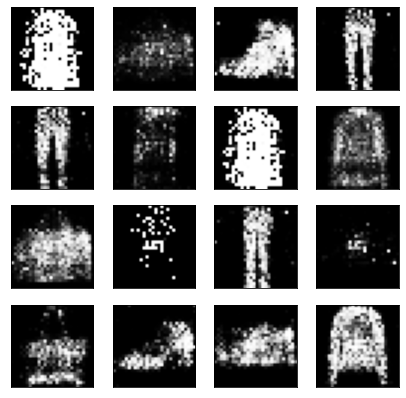

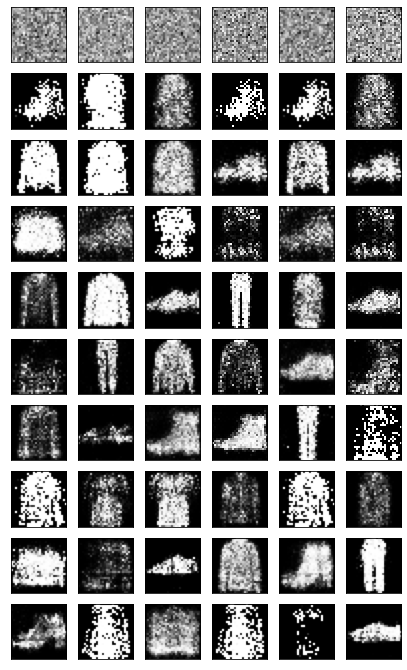

In [16]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


view_samples(-1, samples)

rows = 10
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)